In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob

from scipy.signal import find_peaks
from scipy.interpolate import interp1d 
from tqdm import tqdm_notebook
from skimage.restoration import denoise_tv_chambolle


from IPython import display

In [2]:
"""
Uploading data

Parameters: 
-----------
path: string
    path to the folder with spectrums 

Returns:
-----------
mem_spectrum, niom_spectrum: pd.DataFrame
    MEM and NIOM spectrum
"""

def upload_data(path):
    mem_spectrum = pd.read_csv(path + '\Spectrum of electrode LD.csv', index_col=0)
    niom_spectrum = pd.read_csv(path + '\Spectrum of optical LD.csv', index_col=0)
    return(mem_spectrum, niom_spectrum)
    
path = r'C:\Users\ecath\Desktop\Research\Raw Data\Spectrum LD'
mem_spectrum, niom_spectrum = upload_data(path)

C:\Users\ecath\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
"""
Applying total variation regularization to the spectrum

Parameters: 
-----------
df: pd.DataFrame
    dataframe with spectrums 
weight: float 
    coefficient of regularization 
    
Returns:
-----------
tv_spectrum: pd.DataFrame
    Spectrum preprocessed by TV denoising 

"""


def tv_denoising(df, weight):
    
    tv_spectrum = pd.DataFrame()
    df_ = df.drop(['target'])

    for i in tqdm_notebook(range(df.shape[1]//2)):
        x = df_[df_.columns[1::2]].iloc[:, i]
        y = df_[df_.columns[::2]].iloc[:, i]
        x = x[x != 0]
        y = y[y != 0]
        tv_denoised = denoise_tv_chambolle(y, weight=weight)
        tv_spectrum = pd.concat([tv_spectrum, tv_denoised, x], axis=1, sort=False)
        tv_spectrum.fillna(0, inplace=True)
    tv_spectrum = pd.concat([tv_spectrum, pd.DataFrame(df.iloc[-1,:]).transpose()], axis=0, sort=False)
    return(tv_spectrum)

mem_spec_tv = tv_denoising(mem_spectrum, 0.001)
niom_spec_tv = tv_denoising(niom_spectrum, 0.25)

# to save the denoised dataframes
# mem_spec_tv.to_csv(r'C:\Users\ecath\Desktop\Research\Raw Data\Spectrum LD\Spectrum of electrode tv denoised.csv', sep=',', index=True)
# niom_spec_tv.to_csv(r'C:\Users\ecath\Desktop\Research\Raw Data\Spectrum LD\Spectrum of optical tv denoised.csv', sep=',', index=True)

C:\Users\ecath\Anaconda3\lib\site-packages\skimage\restoration\_denoise.py:236: RuntimeWarning: invalid value encountered in double_scalars
  E /= float(image.size)


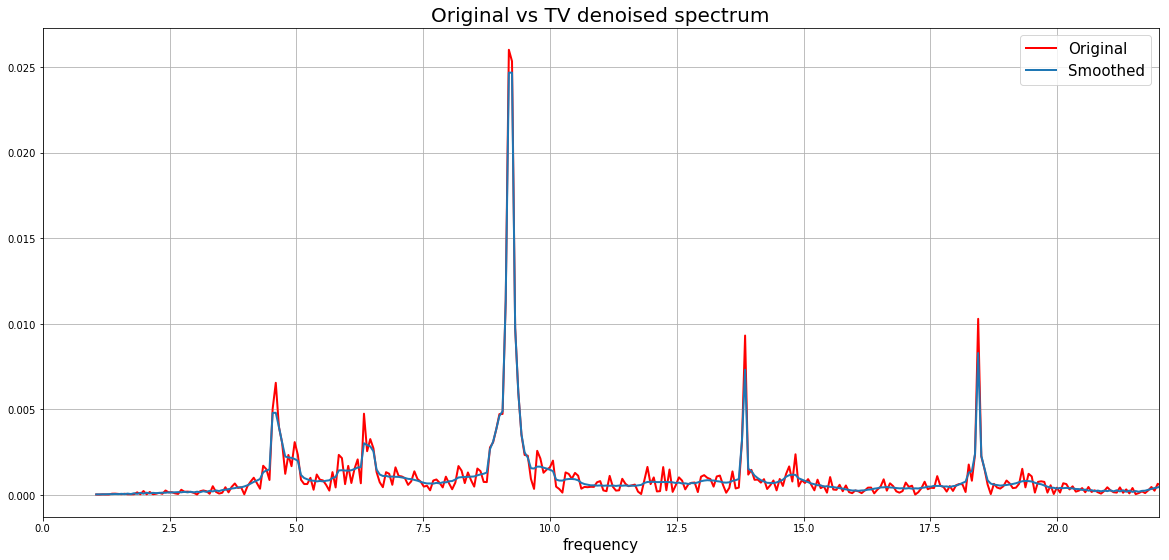

In [35]:
mem_spec = mem_spectrum.drop(['target'])
mem_tv = mem_spec_tv.drop(['target'])

x = mem_spec[mem_spec.columns[101]]
y = mem_spec[mem_spec.columns[100]]
y_tv = mem_tv[mem_tv.columns[100]]


x = x[x != 0]
y = y[y != 0]
y_tv = y_tv[y_tv != 0]


plt.figure(figsize=(20, 9))

plt.plot(x, y, 'r-', label='Original', linewidth=2)
plt.plot(x, y_tv, label='Smoothed', linewidth=2)
plt.grid()
plt.title('Original vs TV denoised spectrum', fontsize=20)
plt.xlabel('frequency', fontsize=15)
plt.legend(fontsize=15)
plt.xlim(0, 22)


# plt.subplot(121)
# plt.plot(x, y, 'r')
# plt.grid()
# plt.title('Original spectrum', fontsize=20)

# plt.subplot(122)
# plt.plot(x, y_tv)
# plt.grid()
# plt.title('TV denoised spectrum', fontsize=20)

plt.savefig(r'C:\Users\ecath\Desktop\tv_denoising.png', format='PNG')
plt.show()
